In [1]:

!pip install transformers
!pip install pyswarm

     |████████████████████████████████| 4.0 MB 12.3 MB/s 
     |████████████████████████████████| 77 kB 6.9 MB/s 
     |████████████████████████████████| 880 kB 42.0 MB/s 
     |████████████████████████████████| 6.6 MB 47.1 MB/s 
     |████████████████████████████████| 596 kB 41.4 MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.53-py3-none-any.whl size=895260 sha256=cf7d575b8b9dcbeb245a811b2bcb0f47bee00062520a7e13126d3e19eb49f331
  Stored in directory: /root/.cache/pip/wheels/87/39/dd/a83eeef36d0bf98e7a4d1933a4ad2d660295a40613079bafc9
Successfully built sacremoses
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
  Created wheel for pyswarm: filename=pyswarm-0.6-py3-none-any.whl size=4481 sha256=7c1bc4cad5fe12dcb9fc8126c843e2eb18e7055b6a3f71638b0123b7b1c97144
  Stored in directory: /root/.cache/pip/wheels/ac/69/65/926e9c51b9fa99757cb43e8f6b74c5e6bb8b41a038b35c2db1
Successful

In [2]:
import pandas as pd
import torch
import numpy as np
from transformers import BertTokenizer, BertModel, RobertaTokenizer, RobertaModel, Trainer, TrainingArguments, BertForSequenceClassification
from transformers import DistilBertTokenizer, DistilBertModel
from torch import nn
from torch.optim import Adam
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from transformers import EarlyStoppingCallback
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from torch.utils.data import Dataset, DataLoader
import logging
logging.basicConfig(level=logging.ERROR)
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from pyswarm import pso

In [3]:
from google.colab import files
uploaded = files.upload()

Saving en_dataset.csv to en_dataset.csv


In [32]:
import io
df = pd.read_csv(io.BytesIO(uploaded['en_dataset.csv']))
#df = pd.read_csv(io.BytesIO(uploaded['fr_dataset.csv']))

In [33]:
df.drop(['HITId','directness','annotator_sentiment','target','group'],axis=1,inplace=True)

In [34]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased', truncation=True, do_lower_case=True)

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [6]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')   

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [20]:
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

In [35]:

def sentiment(data):

    for i in range(data.shape[0]):
        sentence = data['sentiment'][i]
        if 'normal' in sentence:    
            data['sentiment'][i] = 'normal'
        if 'offensive' in sentence:
           if 'offensive' == sentence:
             data['sentiment'][i] = 'offensive'
           else:
             data['sentiment'][i] = 'veryoffensive'
        if 'offensive' not in sentence:
          if 'normal' not in sentence:
            data['sentiment'][i] = 'somewhatoffensive'
        
    return data
   
df = sentiment(df)

print("The data before performing random sampling and oversampling :\n ", df['sentiment'].value_counts())

class_0 = df[df['sentiment'] == 'normal']
class_1 = df[df['sentiment'] == 'offensive']
class_2 = df[df['sentiment'] == 'somewhatoffensive']
class_3 = df[df['sentiment'] == 'veryoffensive']

class_count_1 , class_count_3, class_count_0,class_count_2 = df['sentiment'].value_counts()

class_1_under = class_1.sample(class_count_3, replace=True)
class_2_over = class_2.sample(class_count_3, replace=True)
class_0_over = class_0.sample(class_count_3, replace=True)
df = pd.concat([class_0_over,class_1_under,class_2_over,class_3],axis=0)

print("The data after performing random undersampling on class 'offensive' and random oversampling on class 'normal' , class 'somewhatoffensive':\n ", df['sentiment'].value_counts())

labels = {'normal'   :0,'offensive':1,'somewhatoffensive':2,'veryoffensive':3} 
class Dataset(torch.utils.data.Dataset):

    def __init__(self, df):

        self.labels = [labels[label] for label in df['sentiment']]
        self.texts = [tokenizer(tweet, 
                               padding='max_length', max_length = 512, truncation=True,
                                return_tensors="pt") for tweet in df['tweet']]

    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self, idx):
        # Fetch a batch of labels
        return np.array(self.labels[idx])

    def get_batch_texts(self, idx):
        # Fetch a batch of inputs
        return self.texts[idx]

    def __getitem__(self, idx):

        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)

        return batch_texts, batch_y

The data before performing random sampling and oversampling :
  offensive            2954
veryoffensive        1066
normal                950
somewhatoffensive     677
Name: sentiment, dtype: int64
The data after performing random undersampling on class 'offensive' and random oversampling on class 'normal' , class 'somewhatoffensive':
  normal               1066
offensive            1066
somewhatoffensive    1066
veryoffensive        1066
Name: sentiment, dtype: int64


In [ ]:
def sentiment(data):

    for i in range(data.shape[0]):
        sentence = data['sentiment'][i]
        if 'normal' not in sentence:    
            data['sentiment'][i] = 1
        else:
            data['sentiment'][i] = 0
    return data
   
df = sentiment(df)

print("The data before performing random sampling and oversampling :\n ", df['sentiment'].value_counts())

class_0 = df[df['sentiment'] == 0]
class_1 = df[df['sentiment'] == 1]

class_count_1 , class_count_0 = df['sentiment'].value_counts()

print(class_count_0,class_count_1)

class_1_under = class_1.sample(class_count_0, replace=True)
# class_0_over = class_0.sample(class_count_3, replace=True)
# class_2_over = class_2.sample(class_count_3, replace=True)
df = pd.concat([class_0,class_1_under],axis=0)

print("The data after performing random sampling and oversampling :\n ", df['sentiment'].value_counts())

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained("bert-base-uncased",num_labels=2)
X = list(df["tweet"])
y = list(df["sentiment"])
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)
X_train_tokenized = tokenizer(X_train, padding=True, truncation=True, max_length=512)
X_val_tokenized = tokenizer(X_val, padding=True, truncation=True, max_length=512)

class Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels=None):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        if self.labels:
            item["labels"] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.encodings["input_ids"])

train_dataset = Dataset(X_train_tokenized, y_train)
val_dataset = Dataset(X_val_tokenized, y_val)

The data before performing random sampling and oversampling :
  1    4288
0    1359
Name: sentiment, dtype: int64
1359 4288
The data after performing random sampling and oversampling :
  0    1359
1    1359
Name: sentiment, dtype: int64


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [36]:
class DistilBERTClass(nn.Module):

    def __init__(self):
        super(DistilBERTClass, self).__init__()
        self.l1 = DistilBertModel.from_pretrained("distilbert-base-uncased")
        self.pre_classifier = torch.nn.Linear(768, 768)
        self.dropout = torch.nn.Dropout(0.3)
        self.classifier = torch.nn.Linear(768, 4)
   #     self.classifier = torch.nn.ReLU()

    def forward(self, input_ids, attention_mask):
        output_1 = self.l1(input_ids=input_ids, attention_mask=attention_mask)
        hidden_state = output_1[0]
        pooler = hidden_state[:, 0]
        pooler = self.pre_classifier(pooler)
        pooler = torch.nn.ReLU()(pooler)
        pooler = self.dropout(pooler)
        output = self.classifier(pooler)
 
        return output

In [8]:
class BertClassifier(nn.Module):

    def __init__(self, dropout=0.3):

        super(BertClassifier, self).__init__()

        self.bert = BertModel.from_pretrained('bert-base-cased')
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(768, 4)
        # self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, input_id, mask):

        _, pooled_output = self.bert(input_ids= input_id, attention_mask=mask,return_dict=False)
        dropout_output = self.dropout(pooled_output)
        linear_output = self.linear(dropout_output)
        final_layer = self.softmax(linear_output)

        return final_layer

In [22]:
class RobertaClassifier(nn.Module):

    def __init__(self, dropout=0.3):

        super(RobertaClassifier, self).__init__()

        self.roberta = RobertaModel.from_pretrained('roberta-base')
        self.dropout = nn.Dropout(dropout)        
        self.linear = nn.Linear(768, 4)
       # self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)


    def forward(self, input_id, mask):

        _, pooled_output = self.roberta(input_ids= input_id, attention_mask=mask,return_dict=False)
        dropout_output = self.dropout(pooled_output)
        linear_output = self.linear(dropout_output)
      #  final_layer = self.relu(linear_output)
        final_layer = self.softmax(linear_output)

        return final_layer

In [37]:
train_loss = []
val_loss = []
train_acc = []
val_acc = []
def train(model, train_data, val_data, learning_rate, epochs):

    train, val = Dataset(train_data), Dataset(val_data)

    train_dataloader = torch.utils.data.DataLoader(train, batch_size=2, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val, batch_size=2)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    criterion = nn.CrossEntropyLoss()
 
    optimizer = Adam(model.parameters(), lr= learning_rate)

    if use_cuda:

            model = model.cuda()
            criterion = criterion.cuda()

    for epoch_num in range(epochs):

            total_acc_train = 0
            total_loss_train = 0

            for train_input, train_label in tqdm(train_dataloader):

                train_label = train_label.to(device)
                mask = train_input['attention_mask'].to(device)
                input_id = train_input['input_ids'].squeeze(1).to(device)

                output = model(input_id, mask)

                batch_loss = criterion(output, train_label)
                total_loss_train += batch_loss.item()
                
                acc = (output.argmax(dim=1) == train_label).sum().item()
                total_acc_train += acc

                model.zero_grad()
                batch_loss.backward()
                optimizer.step()
            
            total_acc_val = 0
            total_loss_val = 0

            with torch.no_grad():

                for val_input, val_label in val_dataloader:

                    val_label = val_label.to(device)
                    mask = val_input['attention_mask'].to(device)
                    input_id = val_input['input_ids'].squeeze(1).to(device)

                    output = model(input_id, mask)

                    batch_loss = criterion(output, val_label)
                    total_loss_val += batch_loss.item()
                    
                    acc = (output.argmax(dim=1) == val_label).sum().item()
                    total_acc_val += acc

            train_loss.append(total_loss_train/len(train_data))
            train_acc.append(total_acc_train/len(train_data))
            val_loss.append(total_loss_val/len(val_data))
            val_acc.append(total_acc_val/len(val_data))
            print(
                f'Epochs: {epoch_num + 1} | Train Loss: {total_loss_train / len(train_data): .3f} | Train Accuracy: {total_acc_train / len(train_data): .3f} | Val Loss: {total_loss_val / len(val_data): .3f} | Val Accuracy: {total_acc_val / len(val_data): .3f}')
    return train_loss, train_acc , val_loss , val_acc        
                  

In [38]:
def evaluate(model, test_data):
    finaloutput = []
    finaltestlabel = []
    test = Dataset(test_data)

    test_dataloader = torch.utils.data.DataLoader(test, batch_size=2)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    if use_cuda:

        model = model.cuda()

    total_acc_test = 0
    with torch.no_grad():

        for test_input, test_label in test_dataloader:

              test_label = test_label.to(device)
              mask = test_input['attention_mask'].to(device)
              input_id = test_input['input_ids'].squeeze(1).to(device)

              output = model(input_id, mask)
              finaloutput.extend(list(output.cpu().detach().numpy()))
              finaltestlabel.extend(list(test_label.cpu().detach().numpy()))

              acc = (output.argmax(dim=1) == test_label).sum().item()
              total_acc_test += acc
    
    print(f'Test Accuracy: {total_acc_test / len(test_data): .3f}')
    return finaloutput , finaltestlabel

In [39]:
np.random.seed(112)
df_train, df_val, df_test = np.split(df.sample(frac=1, random_state=42), 
                                     [int(.8*len(df)), int(.9*len(df))])

print(len(df_train),len(df_val), len(df_test))

3411 426 427


In [12]:
EPOCHS = 2
model = BertClassifier()
LR = 1e-6
              
btrain_loss, btrain_acc , bval_loss , bval_acc  = train(model, df_train, df_val, LR, EPOCHS)

Downloading:   0%|          | 0.00/416M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 1706/1706 [11:43<00:00,  2.43it/s]


Epochs: 1 | Train Loss:  0.693 | Train Accuracy:  0.270 | Val Loss:  0.692 | Val Accuracy:  0.289


100%|██████████| 1706/1706 [11:43<00:00,  2.42it/s]


Epochs: 2 | Train Loss:  0.682 | Train Accuracy:  0.341 | Val Loss:  0.679 | Val Accuracy:  0.298


In [13]:
bertoutput , testlabel = evaluate(model, df_test)


Test Accuracy:  0.351


In [ ]:
bertoutput[0],testlabel[0]

(array([0.27082032, 0.3227652 , 0.0948026 , 0.3116119 ], dtype=float32), 3)

In [14]:
bertoutput = np.array(bertoutput)                 

In [15]:
bertoutput1 = np.argmax(bertoutput,axis=1)
accuracy = accuracy_score(testlabel,bertoutput1)
report = classification_report(testlabel,bertoutput1)
cf_mat = confusion_matrix(y_true=testlabel,y_pred=bertoutput1)

In [16]:
print("The results of BERT model for {} Epochs ".format(EPOCHS))
print("Accuracy              :", accuracy)
print("Classification Report :\n", report)
print("Confusion Matrix      :\n", cf_mat)

The results of BERT model for 2 Epochs 
Accuracy              : 0.351288056206089
Classification Report :
               precision    recall  f1-score   support

           0       0.40      0.59      0.48       107
           1       0.31      0.47      0.38       106
           2       0.37      0.31      0.34       111
           3       0.15      0.03      0.05       103

    accuracy                           0.35       427
   macro avg       0.31      0.35      0.31       427
weighted avg       0.31      0.35      0.31       427

Confusion Matrix      :
 [[63 24 15  5]
 [31 50 19  6]
 [22 49 34  6]
 [40 37 23  3]]


In [26]:
EPOCHS = 2
model = RobertaClassifier()
LR = 1e-6
              
rtrain_loss, rtrain_acc , rval_loss , rval_acc  = train(model, df_train, df_val, LR, EPOCHS)

Downloading:   0%|          | 0.00/478M [00:00<?, ?B/s]

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.bias', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 1706/1706 [11:52<00:00,  2.40it/s]


Epochs: 1 | Train Loss:  0.693 | Train Accuracy:  0.266 | Val Loss:  0.689 | Val Accuracy:  0.305


100%|██████████| 1706/1706 [11:52<00:00,  2.40it/s]


Epochs: 2 | Train Loss:  0.669 | Train Accuracy:  0.371 | Val Loss:  0.672 | Val Accuracy:  0.350


In [27]:

robertaoutput , testlabel = evaluate(model, df_test)


Test Accuracy:  0.361


In [28]:
robertaoutput = np.array(robertaoutput)

In [29]:
robertaoutput1 = np.argmax(robertaoutput,axis=1)
accuracy = accuracy_score(testlabel,robertaoutput1)
report = classification_report(testlabel,robertaoutput1)
cf_mat = confusion_matrix(y_true=testlabel,y_pred=robertaoutput1)

In [30]:
print("The results of RoBERTa model for {} Epochs ".format(EPOCHS))
print("Accuracy              :", accuracy)
print("Classification Report :\n", report)
print("Confusion Matrix      :\n", cf_mat)

The results of RoBERTa model for 2 Epochs 
Accuracy              : 0.36065573770491804
Classification Report :
               precision    recall  f1-score   support

           0       0.32      0.63      0.43       107
           1       0.35      0.25      0.29       106
           2       0.42      0.45      0.44       111
           3       0.39      0.11      0.17       103

    accuracy                           0.36       427
   macro avg       0.37      0.36      0.33       427
weighted avg       0.37      0.36      0.33       427

Confusion Matrix      :
 [[67 15 19  6]
 [46 26 26  8]
 [38 20 50  3]
 [56 13 23 11]]


In [40]:
EPOCHS = 2
model = DistilBERTClass()
LR = 1e-6
              
dtrain_loss, dtrain_acc , dval_loss , dval_acc  = train(model, df_train, df_val, LR, EPOCHS)

Downloading:   0%|          | 0.00/256M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.bias', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 1706/1706 [06:08<00:00,  4.63it/s]


Epochs: 1 | Train Loss:  0.693 | Train Accuracy:  0.260 | Val Loss:  0.693 | Val Accuracy:  0.270


100%|██████████| 1706/1706 [06:08<00:00,  4.63it/s]


Epochs: 2 | Train Loss:  0.681 | Train Accuracy:  0.341 | Val Loss:  0.681 | Val Accuracy:  0.303


In [41]:
distillbertoutput , testlabel = evaluate(model, df_test)


Test Accuracy:  0.316


In [42]:
distillbertoutput = np.array(distillbertoutput)                 

In [43]:
distillbertoutput1 = np.argmax(distillbertoutput,axis=1)
accuracy = accuracy_score(testlabel,distillbertoutput1)
report = classification_report(testlabel,distillbertoutput1)
cf_mat = confusion_matrix(y_true=testlabel,y_pred=distillbertoutput1)

In [44]:
print("The results of DistillBERT model for {} Epochs ".format(EPOCHS))
print("Accuracy              :", accuracy)
print("Classification Report :\n", report)
print("Confusion Matrix      :\n", cf_mat)

The results of DistillBERT model for 2 Epochs 
Accuracy              : 0.3161592505854801
Classification Report :
               precision    recall  f1-score   support

           0       0.33      0.47      0.39       107
           1       0.22      0.10      0.14       106
           2       0.39      0.30      0.34       111
           3       0.29      0.40      0.34       103

    accuracy                           0.32       427
   macro avg       0.31      0.32      0.30       427
weighted avg       0.31      0.32      0.30       427

Confusion Matrix      :
 [[50 14 15 28]
 [33 11 22 40]
 [30 16 33 32]
 [37 10 15 41]]


In [ ]:
def compute_metrics(p):
    pred, labels = p
    pred = np.argmax(pred, axis=1)

    accuracy = accuracy_score(y_true=labels, y_pred=pred)
    recall = recall_score(y_true=labels, y_pred=pred)
    precision = precision_score(y_true=labels, y_pred=pred)
    f1 = f1_score(y_true=labels, y_pred=pred)

    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}

In [ ]:
args = TrainingArguments(
    output_dir="output",
    evaluation_strategy="steps",
    eval_steps=500,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=10,
    seed=0,
    load_best_model_at_end=True,
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [ ]:
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)],
)

trainer.train()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 2174
  Num Epochs = 10
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 2720


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
500,0.527600,1.066330,0.601103,0.621849,0.538182,0.576998
1000,0.402500,1.510123,0.564338,0.571970,0.549091,0.560297
1500,0.251300,1.881502,0.586397,0.606838,0.516364,0.557957
2000,0.142900,2.083155,0.582721,0.596774,0.538182,0.565966


***** Running Evaluation *****
  Num examples = 544
  Batch size = 8
Saving model checkpoint to output/checkpoint-500
Configuration saved in output/checkpoint-500/config.json
Model weights saved in output/checkpoint-500/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 544
  Batch size = 8
Saving model checkpoint to output/checkpoint-1000
Configuration saved in output/checkpoint-1000/config.json
Model weights saved in output/checkpoint-1000/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 544
  Batch size = 8
Saving model checkpoint to output/checkpoint-1500
Configuration saved in output/checkpoint-1500/config.json
Model weights saved in output/checkpoint-1500/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 544
  Batch size = 8
Saving model checkpoint to output/checkpoint-2000
Configuration saved in output/checkpoint-2000/config.json
Model weights saved in output/checkpoint-2000/pytorch_model.bin


Training completed. Do not forget to 

TrainOutput(global_step=2000, training_loss=0.33106794357299807, metrics={'train_runtime': 630.6147, 'train_samples_per_second': 34.474, 'train_steps_per_second': 4.313, 'total_flos': 386106223742760.0, 'train_loss': 0.33106794357299807, 'epoch': 7.35})

In [ ]:
trainer.evaluate()

***** Running Evaluation *****
  Num examples = 544
  Batch size = 8


{'epoch': 5.0,
 'eval_accuracy': 0.5514705882352942,
 'eval_f1': 0.5040650406504065,
 'eval_loss': 0.7696777582168579,
 'eval_precision': 0.5714285714285714,
 'eval_recall': 0.4509090909090909,
 'eval_runtime': 4.8879,
 'eval_samples_per_second': 111.296,
 'eval_steps_per_second': 13.912}

In [ ]:
bertoutput.shape,robertaoutput.shape,distillbertoutput.shape

((376,), (376,), (376,))

In [46]:
def objectiveFunction(x):
   weighted_bert_score = x[0] * bertoutput
   weighted_roberta_score = x[1] * robertaoutput 
   weighted_distillbertoutput_score = x[2] * distillbertoutput
   
   fusion_output = weighted_bert_score + weighted_roberta_score + weighted_distillbertoutput_score
   
   print('fusion shape',fusion_output.shape)

  # calculate the accuracy score using fusion_output
   acc = accuracy_score(testlabel,np.argmax(fusion_output,axis=1))  

   return 1- acc

In [47]:
position ,fitness = pso(objectiveFunction,lb=[0,0,0],ub=[1,1,1])

Streaming output truncated to the last 5000 lines.
fusion shape (427, 4)
fusion shape (427, 4)
fusion shape (427, 4)
fusion shape (427, 4)
fusion shape (427, 4)
fusion shape (427, 4)
fusion shape (427, 4)
fusion shape (427, 4)
fusion shape (427, 4)
fusion shape (427, 4)
fusion shape (427, 4)
fusion shape (427, 4)
fusion shape (427, 4)
fusion shape (427, 4)
fusion shape (427, 4)
fusion shape (427, 4)
fusion shape (427, 4)
fusion shape (427, 4)
fusion shape (427, 4)
fusion shape (427, 4)
fusion shape (427, 4)
fusion shape (427, 4)
fusion shape (427, 4)
fusion shape (427, 4)
fusion shape (427, 4)
fusion shape (427, 4)
fusion shape (427, 4)
fusion shape (427, 4)
fusion shape (427, 4)
fusion shape (427, 4)
fusion shape (427, 4)
fusion shape (427, 4)
fusion shape (427, 4)
fusion shape (427, 4)
fusion shape (427, 4)
fusion shape (427, 4)
fusion shape (427, 4)
fusion shape (427, 4)
fusion shape (427, 4)
fusion shape (427, 4)
fusion shape (427, 4)
fusion shape (427, 4)
fusion shape (427, 4)
fus

In [48]:
fitness

0.585480093676815

In [49]:
position

array([0.5658646 , 0.12349002, 0.26420274])

In [50]:
weighted_bert_score = position[0] * bertoutput
weighted_roberta_score = position[1] * robertaoutput 
weighted_distillbertoutput_score = position[2] * distillbertoutput
   
fusion_output = weighted_bert_score + weighted_roberta_score + weighted_distillbertoutput_score
acc = accuracy_score(testlabel,np.argmax(fusion_output,axis=1))



In [51]:
print(fusion_output)

[[ 0.47043794  0.03437725 -0.00156678  0.13631038]
 [ 0.24534523  0.18244207  0.10776994  0.07803439]
 [ 0.06080443  0.16793211  0.15316096  0.23440892]
 ...
 [ 0.12491877  0.24529397  0.14470714  0.07663137]
 [ 0.16162452  0.13793388  0.12370352  0.23835805]
 [ 0.01361534  0.1226144   0.24086262  0.17771877]]


In [52]:
acc

0.41451990632318503

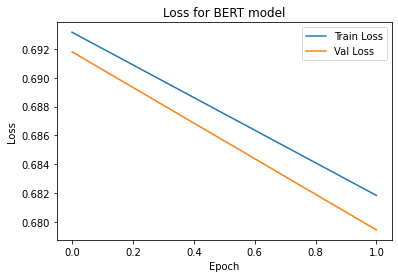

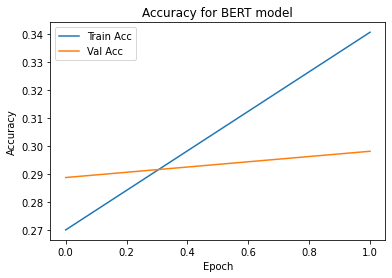

In [17]:
   plt.figure()
   plt.title("Loss for BERT model")
   plt.plot(btrain_loss, label="Train Loss")
   plt.plot(bval_loss, label="Val Loss")
   plt.xlabel("Epoch")
   plt.ylabel("Loss")
   plt.legend()    
   plt.show()

   plt.figure()
   plt.title("Accuracy for BERT model")
   plt.plot(btrain_acc, label="Train Acc")
   plt.plot(bval_acc, label="Val Acc")      
   plt.xlabel("Epoch")
   plt.ylabel("Accuracy")
   plt.legend()    
   plt.show()

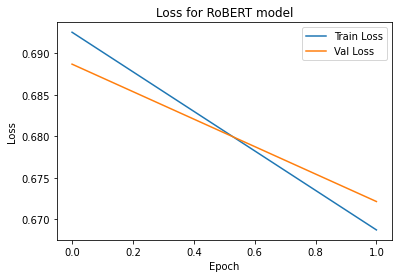

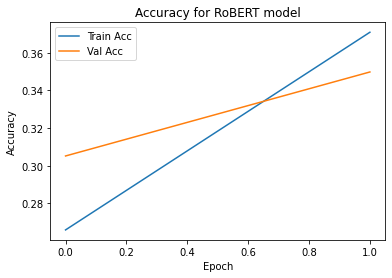

In [31]:
   plt.figure()
   plt.title("Loss for RoBERT model")
   plt.plot(rtrain_loss, label="Train Loss")
   plt.plot(rval_loss, label="Val Loss")
   plt.xlabel("Epoch")
   plt.ylabel("Loss")
   plt.legend()    
   plt.show()

   plt.figure()
   plt.title("Accuracy for RoBERT model")
   plt.plot(rtrain_acc, label="Train Acc")
   plt.plot(rval_acc, label="Val Acc")      
   plt.xlabel("Epoch")
   plt.ylabel("Accuracy")
   plt.legend()    
   plt.show()

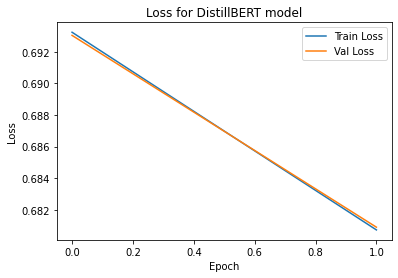

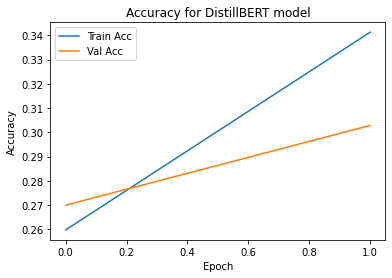

In [45]:
   plt.figure()
   plt.title("Loss for DistillBERT model")
   plt.plot(dtrain_loss, label="Train Loss")
   plt.plot(dval_loss, label="Val Loss")
   plt.xlabel("Epoch")
   plt.ylabel("Loss")
   plt.legend()    
   plt.show()

   plt.figure()
   plt.title("Accuracy for DistillBERT model")
   plt.plot(dtrain_acc, label="Train Acc")
   plt.plot(dval_acc, label="Val Acc")      
   plt.xlabel("Epoch")
   plt.ylabel("Accuracy")
   plt.legend()    
   plt.show()

In [ ]:
# References : 
# 1) https://github.com/marcellusruben/medium-resources/blob/main/Text_Classification_BERT/bert_medium.ipynb
# 2) https://towardsdatascience.com/fine-tuning-pretrained-nlp-models-with-huggingfaces-trainer-6326a4456e7b
